### Preparation (Import Packages)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_plink import read_plink1_bin
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from collections import Counter

import sys, ast
sys.path.insert(0, '../src/')
from annotation import *
from BANN import * # Import annotation code

sys.path.insert(0, '../examples_docs/')

import magenpy as mgp
import viprs as vp

2022-11-26 21:35:58.106908: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-26 21:35:58.260946: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /u/local/apps/python/3.9.6/gcc-4.8.5/lib:/u/local/compilers/intel/2020.4/compilers_and_libraries_2020.4.304/linux/compiler/lib/intel64_lin:/u/local/compilers/intel/2020.4/compilers_and_libraries_2020.4.304/linux/daal/../tbb/lib/intel64_lin/gcc4.4:/u/local/compilers/intel/2020.4/compilers_and_libraries_2020.4.304/linux/daal/../tbb/lib/intel64_lin/gcc4.8:/u/local/compilers/intel/2020.4/compilers_and_l

In [2]:
### ROC Curve
def draw_roc_curve(y_true, y_pred_dict):
    n_classes = 2
    
    plt.figure(figsize=(6, 6))
    for method_name, y_pred in y_pred_dict.items():
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_pred[:, i], y_true[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_pred.ravel(), y_true.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        
        lw = 2
        plt.plot(
            fpr[1],
            tpr[1],
            lw=lw,
            label=f"{method_name} (area = %0.2f)" % roc_auc[1],
        )
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        plt.xlim([-0.05, 1.0])
        plt.ylim([-0.05, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
    plt.show()

### Gene Annotation (only needs to run once)

In [3]:
chr_selected = "22"

data_folder = "/u/home/z/zhengton/project-sriram/CS-M226-Project/data/"
# genotype_prefix = "combined_final_no_dup_chr22"

genotype_prefix = "chr22_filtered/combined_final_no_dup_chr22"
# genotype_prefix = "sample_data/1000G_eur_chr22"

path_to_SNPList = data_folder+genotype_prefix+".map"
path_to_geneList = data_folder+"gene_list.txt"
path_to_selected_geneList = data_folder+f"gene_list_chr{chr_selected}.txt"
file_to_annotationDF=data_folder+f"AnnotationDF_chr{chr_selected}.txt"

In [4]:
geneList_DF = pd.read_csv(path_to_geneList, sep='\t', header=None)
geneList_DF.columns = ["Chromosome", "Start", "End", "GeneID"]
selected_geneList_DF = geneList_DF[geneList_DF.Chromosome == chr_selected]

selected_geneList_DF.to_csv(path_to_selected_geneList, sep='\t', header=False, index=None)

In [5]:
selected_geneList_DF

,Chromosome,Start,End,GeneID
8,22,42692120,42720870,A4GALT
170,22,41469124,41528989,ACO2
191,22,50738223,50745299,ACR
367,22,50481555,50486437,ADM2
373,22,24423596,24442361,ADORA2A
...,...,...,...,...
26450,22,20394114,20408463,ZNF74
26559,22,22513735,22520281,ZNF280A
26560,22,22484425,22509187,ZNF280B
26973,22,28883766,29057488,ZNRF3


In [7]:
path_to_filtered_geneList = data_folder+"/filtered_gene_list.txt"
filtered_geneList_DF = selected_geneList_DF
filtered_geneList_DF
filtered_geneList_DF.to_csv(path_to_filtered_geneList, header=None, index=False, sep='\t')

In [6]:
annotationDF=annotate(path_to_SNPList, path_to_selected_geneList, outputFile=file_to_annotationDF, 
                      intergenic=False, buffer=500, dropSingletons=True)

print(annotationDF)

You have chosen to annotate SNP-sets without intergenic regions and with a buffer of 500bp
Annotating SNP-sets with the corresponding SNPs


100% 2576/2576 [00:01<00:00, 1385.63it/s]


Dropping SNP-sets that are singletons (containing only one SNP) and re-annotating SNPs without them
Annotating SNP-sets with the corresponding SNPs


100% 2576/2576 [00:01<00:00, 1407.49it/s]

Saving annotation results to file /u/home/z/zhengton/project-sriram/CS-M226-Project/data/AnnotationDF_chr22.txt
                GeneID Chromosome       Start         End  \
0               CCT8L2         22  16590757.0  16592810.0   
1               TPTEP1         22  16601910.0  16648830.0   
2    ANKRD62P1-PARP4P3         22  16653708.0  16675540.0   
3                 GAB4         22  16961935.0  17008222.0   
4                CECR7         22  17036569.0  17058792.0   
..                 ...        ...         ...         ...   
406               ARSA         22  50622753.0  50628173.0   
407             SHANK3         22  50674641.0  50733212.0   
408                ACR         22  50738223.0  50745299.0   
409          RPL23AP82         22  50757085.0  50799637.0   
410             RABL2B         22  50767491.0  50783659.0   

                                              SNPindex  \
0                                                  [0]   
1                                      

In [ ]:
# annotationDF = pd.read_csv(file_to_annotationDF, index_col=0, sep='\t')
# selected_annotationDF = annotationDF[annotationDF.Chromosome == int(chr_selected)]
# selected_annotationDF.SNPindex = selected_annotationDF.SNPindex.apply(lambda x: np.array(ast.literal_eval(x)) - selected_SNPList_DF.index[0])
# selected_annotationDF.VariantID = selected_annotationDF.VariantID.apply(lambda x: ast.literal_eval(x))
# selected_annotationDF = selected_annotationDF.reset_index().drop(columns=['index'])

# selected_SNPList_DF = selected_SNPList_DF.reset_index().drop(columns=['index'])

In [7]:
mask_outputFile=data_folder+f"chr{chr_selected}_Mask.txt"
mask = getMaskMatrix(path_to_SNPList, annotationDF, mask_outputFile)
print(mask)

creating mask


100% 411/411 [00:00<00:00, 8080.83it/s]


Saving annotation mask to file /u/home/z/zhengton/project-sriram/CS-M226-Project/data/chr22_Mask.txt in tab-delimited format
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


### Load Genotype

In [8]:
bfile=data_folder+genotype_prefix

bed = bfile+'.bed'
fam = bfile+'.fam'
bim = bfile+'.bim'

G = read_plink1_bin(bed, bim, fam, verbose=True)

Mapping files: 100% 3/3 [00:00<00:00, 34.27it/s]


In [9]:
# sub_G = G.where(G.chrom == chr_selected, drop=True)
# sub_G
G

<xarray.DataArray 'genotype' (sample: 2504, variant: 2576)>
dask.array<transpose, shape=(2504, 2576), dtype=float32, chunksize=(1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * sample   (sample) object 'HG00096' 'HG00097' ... 'NA21143' 'NA21144'
  * variant  (variant) <U11 'variant0' 'variant1' ... 'variant2575'
    fid      (sample) object 'HG00096' 'HG00097' ... 'NA21143' 'NA21144'
    iid      (sample) object 'HG00096' 'HG00097' ... 'NA21143' 'NA21144'
    father   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    mother   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    gender   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    trait    (sample) object '-9' '-9' '-9' '-9' '-9' ... '-9' '-9' '-9' '-9'
    chrom    (variant) object '22' '22' '22' '22' '22' ... '22' '22' '22' '22'
    snp      (variant) object 'rs201574129' 'rs2078654' ... 'rs28852528'
    cm       (variant) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    pos      (variant) int32 16591627 16636637 16673521 ... 50789720 50791182
    a0       (variant) object 'T' 'C' 'C' 'A' 'G' 'G' ... 'G' 'C' 'T' 'T' 'A'
    a1       (variant) object 'A' 'T' 'T' 'G' 'A' 'T' ... 'C' 'T' 'C' 'C' 'C'

In [10]:
X = G.values

print(X.shape)
N, p = X.shape

(2504, 2576)


### Subsample Genotype

In [11]:
# p = 3000
# nSNPs= p

# subset_X = X[:, :p]
# subset_mask = mask[:p, :]
# subset_mask = subset_mask[:, subset_mask.any(0)]

### Simulate Phenotypes

In [12]:
# ############### SIMULATING PHENOTYPES #################
# Defining the parameters of the phenotype simulations:

H2 = 0.6 #Broad-sense heritability, meaning 60% of phenotypic variation is explained by genotypic variation.
rho= 1 #All of the heritability comes from additive effects
causal_indices=np.arange(0,np.int32(0.01*p)) #Pick the first 1% of all SNPs to have non-zero effect sizes
ncausal=len(causal_indices)

# Simulate phenotype data based on additive effects:

Xadditive=X[:, causal_indices] # Get the causal SNP values
betaAdd= np.repeat(1, ncausal)# Initialize all effect sizes for these SNPs as "1"
#Initialize the value of the portion of phenotypic variation explained by the additive effects as XB:
y_additive=np.dot(Xadditive, betaAdd)
# Re-scale additive effect sizes based on H^2*rho:
betaAdd= betaAdd * np.sqrt(H2*rho/np.var(y_additive))
# Update y_additive based on effect sizes:
y_additive=np.dot(Xadditive, betaAdd) 


Xepi=[]
for i in causal_indices:
    for j in range(i+1, causal_indices[-1]+1):
        Xepi.append(np.multiply(X[:, i], X[:, j]))
Xepi=np.column_stack(Xepi) #Matrix that holds the values for 
# pairwise interactions between all causal SNPs.

betaEpi= (np.array([1]*Xepi.shape[1])).reshape(-1,1) #Similar to the additive effects,
# epistatic effect sizes are initialized as 1 and will be corrected below.
y_epi= np.dot(Xepi, betaEpi)
betaEpi= betaEpi* np.sqrt(H2*(1-rho)/np.var(y_epi))
y_epi= np.dot(Xepi, betaEpi) # Final value for the portion of phenotypes explained by
#the epistatic effects



# Simulate random noise (drawn from standard normal distribution) for the rest of phenotypic variation (40%):
y_noise = np.random.normal(size=N)
y_noise = y_noise * np.sqrt((1 - H2) / np.var(y_noise))

# Add y_additive and y_noise to get the final simulated phenotypes:
y = np.add(y_additive.reshape(N, 1), y_noise.reshape(N, 1)) 
# y = np.add(y_additive.reshape(N, 1),y_epi.reshape(N, 1), y_noise.reshape(N, 1)) 
print("Shape of the phenotype array:", y.shape)

Shape of the phenotype array: (378, 1)


In [60]:
# g_sim = mgp.GWASimulator(bed, pi=[0.9, 0.1], h2=0.6)
# g_sim.simulate()

> Reading BED file...
> Generating polygenic scores...


In [61]:
# causal_indices = np.where(g_sim.get_causal_status()[22] == True)[0]
# y = g_sim.to_phenotype_table()['phenotype'].values

In [13]:
# np.savetxt("X.txt", subset_X, delimiter=" ")
np.savetxt("y_linear.txt", y, delimiter=" ")

In [120]:
# %%capture
# !pip uninstall --y tensorflow
# !pip install tensorflow

(2504, 1)

### Run BANNs (original version)

In [62]:
# X = np.loadtxt("X.txt")
# y = np.loadtxt("y.txt")
mask = np.loadtxt(data_folder+f"chr{chr_selected}_Mask.txt")

# p = 3000
# subset_mask = mask[:p, :]
# subset_mask = subset_mask[:, subset_mask.any(0)]

Welcome to BANNs. Please make sure SNPs in the SNP List you provide are in the same order as in the genotype matrix. Results we return will be in the order of SNP annotations and SNP-set annotations.
(2504,)
20/20 [==============================] - 437s 22s/step
(2504, 20)
(2504,)
20/20 [==============================] - 2s 93ms/step
PVE
0.39440537478090504
0.35758068248033686


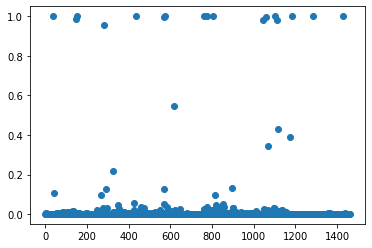

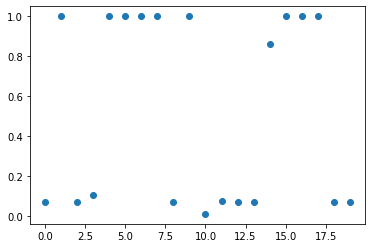

In [63]:
bann=BANNs(X,y, mask, nModelsSNP=20, nModelsSET=20)
[SNP_layer, SET_layer]=bann.run(nonlinear_flag=False)
print("PVE")
print(SNP_layer.pve)
print(SET_layer.pve)

SNPpips=SNP_layer.pip
SETpips=SET_layer.pip

plt.scatter(np.arange(len(SNPpips)), SNPpips)
plt.show()

plt.scatter(np.arange(len(SETpips)), SETpips)
plt.show()

In [64]:
num_snps = X.shape[1]

y_true = np.zeros(num_snps, dtype=int)
y_true[causal_indices] = 1
y_true_one_hot = np.zeros((num_snps, 2), dtype=int)
y_true_one_hot[np.arange(num_snps), y_true] = 1
y_true_one_hot

array([[1, 0],
       [0, 1],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [78]:
pip_threshold = 0.5
y_bann = np.zeros(num_snps, dtype=int)
y_bann[np.where(SNPpips >= pip_threshold)[0]] = 1

y_bann_one_hot = np.zeros((num_snps, 2), dtype=int)
y_bann_one_hot[np.arange(num_snps), y_bann] = 1
y_bann_one_hot

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

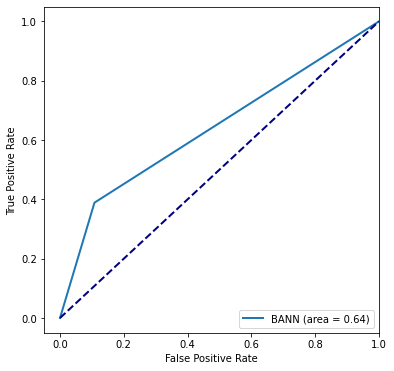

In [89]:
draw_roc_curve(y_true_one_hot, {"BANN": y_bann_one_hot})

### Comparison with other methods

#### Linear Regression

In [71]:
g_sim.perform_gwas()
gwas_table = g_sim.to_summary_statistics_table()

> Performing GWAS...


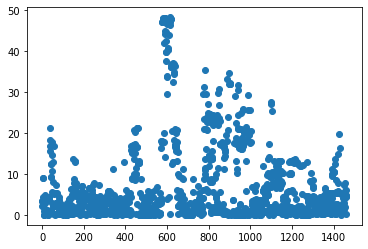

In [75]:
gwas_pval = gwas_table['PVAL'].values
plt.scatter(np.arange(len(gwas_pval)), -np.log10(gwas_pval))
plt.show()

In [97]:
pval_threshold = 0.05/len(gwas_pval)

y_gwas = np.zeros(num_snps, dtype=int)
y_gwas[np.where(gwas_pval <= pval_threshold)[0]] = 1

y_gwas_one_hot = np.zeros((num_snps, 2), dtype=int)
y_gwas_one_hot[np.arange(num_snps), y_gwas] = 1
y_gwas_one_hot

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [1, 0],
       [0, 1]])

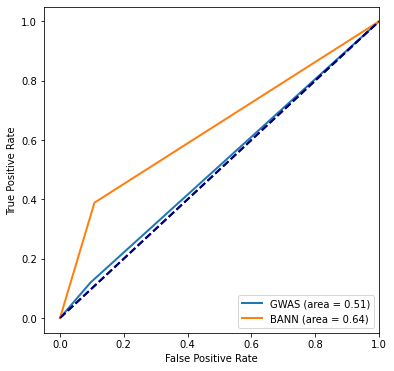

In [93]:
draw_roc_curve(y_true_one_hot, {"GWAS": y_gwas_one_hot, "BANN": y_bann_one_hot})

#### VIPRS

In [106]:
g_sim.sample_size

2504

In [149]:
g_sim.compute_ld('windowed',
                        output_dir='temp',
                         window_size=10)
v = vp.VIPRS(g_sim)

> Computing LD matrix...


> Initializing model parameters
> Loading LD matrices into memory...
> Performing model fit...
> Using up to 1 threads.


  0% 1/1000 [00:00<00:27, 36.61it/s]


OptimizationDivergence: Stopping at iteration 2: The optimization algorithm is not converging!
Previous ELBO: 1469029996875057.750000 | Current ELBO: 3239410264823669.000000

In [136]:
v.update_theta_history()

In [143]:
v.Nj

{22: array([2504., 2504., 2504., ..., 2504., 2504., 2504.])}

### Run Kernel-BANNs

Welcome to BANNs. Please make sure SNPs in the SNP List you provide are in the same order as in the genotype matrix. Results we return will be in the order of SNP annotations and SNP-set annotations.
(2504,)
20/20 [==============================] - 208s 10s/step
(2504, 43)
(2504,)
20/20 [==============================] - 2s 113ms/step
constructing kernelized features...
43/43 [==============================] - 1s 28ms/step
start optional layer: SET_nonlinear_layer...
(2504,)
20/20 [==============================] - 100s 5s/step
PVE
0.442262265269501
0.38298571152736566
0.02673606374195663


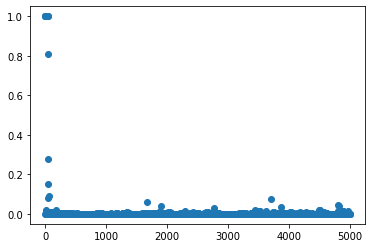

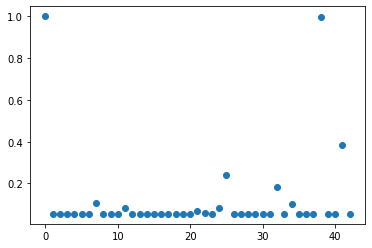

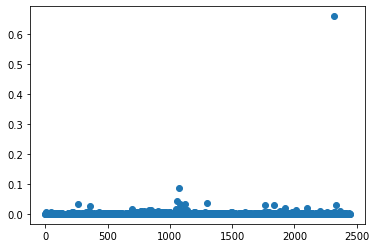

In [6]:
bann=BANNs(X,y, subset_mask, nModelsSNP=20, nModelsSET=20, nModelsSET_nonlinear=20, epi_p = 0.1)
[SNP_layer, SET_layer, SET_layer_nonlinear]=bann.run(nonlinear_flag=True)
print("PVE")
print(SNP_layer.pve)
print(SET_layer.pve)
print(SET_layer_nonlinear.pve)

SNPpips=SNP_layer.pip
SETpips=SET_layer.pip
SET_nonlinear_pips=SET_layer_nonlinear.pip

plt.scatter(np.arange(len(SNPpips)), SNPpips)
plt.show()

plt.scatter(np.arange(len(SETpips)), SETpips)
plt.show()

plt.scatter(np.arange(len(SET_nonlinear_pips)), SET_nonlinear_pips)
plt.show()

### archive code

In [149]:
# snp_clustering = DBSCAN(eps=0.1, min_samples=2).fit(SNPpips.reshape(-1, 1))
# dict_labels_snp = Counter(snp_clustering.labels_)
# del dict_labels_snp[-1]
# snp_level_indices = np.where(snp_clustering.labels_ == min(dict_labels_snp, key=dict_labels_snp.get))[0]
# set_clustering = DBSCAN(eps=0.1, min_samples=2).fit(SETpips.reshape(-1, 1))
# dict_labels_set = Counter(set_clustering.labels_)
# del dict_labels_set[-1]
# set_level_indices = np.where(set_clustering.labels_ == min(dict_labels_set, key=dict_labels_set.get))[0]
# potential_indices = np.sort(np.array(list(set(set_level_indices).union(snp_level_indices))))
# print(snp_level_indices)
# print(set_level_indices)
# print(potential_indices)

[ 0  1 16 19 33 41 59 73 77]
[ 0  7 38 47]
[ 0  1  7 16 19 33 38 41 47 59 73 77]


In [150]:
# subset_mask[77]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [152]:
# nSets_selected = list(set(np.hstack(list(map(lambda x: np.where(x == 1)[0], subset_mask[potential_indices, :])))))
# if len(nSets_selected) <= 0:
#     print("no SNP Sets selected")
# elif len(nSets_selected) == 1:
#     potential_sets = np.array([nSets_selected[0]-1, nSets_selected[0]+1])
#     potential_sets = potential_sets[potential_sets >= 0]
#     potential_sets = potential_sets[potential_sets < selected_mask.shape[1]]
    
#     nSets_selected.extend(potential_sets)
    
# print(nSets_selected)

[0]


In [153]:
# potential_indices = np.concatenate([np.where(subset_mask[:, i] == 1)[0] for i in nSets_selected])
# print(len(potential_indices))

467


In [154]:
# X_selected = subset_X[:, potential_indices]
# mask_selected = subset_mask[potential_indices, :]
# mask_selected = mask_selected[:, mask_selected.any(0)]
# nSets_selected = mask_selected.shape[1]

# for i in range(0, nSets_selected):
#     indices = np.where(mask_selected[:, i] == 1)[0]
#     if len(indices) <= 1:
#         X_selected = np.delete(X_selected, indices, axis=1)
#         mask_selected = np.delete(mask_selected, indices, axis=0)
        
        
# mask_selected = mask_selected[:, mask_selected.any(0)]
# nSets_selected = mask_selected.shape[1]

# X_epi = []
# num_feature_in_sets = []
# for i in range(0, nSets_selected):
#     indices = np.where(mask_selected[:, i] == 1)[0]
#     current_X = X_selected[:, indices]
    
# #     Z = []
# #     for i in range(len(indices)):
# #         for j in range(i+1, len(indices)):
# #             Z.append(np.multiply(current_X[:, i], current_X[:, j]))
# #     Z  = np.column_stack(Z)
    
#     rff_kernel = RFF_gpytorch(gamma=0.1, n_components=4*len(indices),seed=111)
#     Z = rff_kernel.fit_transform(X_selected[:, indices])
    
#     X_epi.append(Z)
#     num_feature_in_sets.append(Z.shape[1])
    
# X_epi=np.column_stack(X_epi)
# dim_set = X_epi.shape[1]//nSets_selected ## number of features per SNP set

# mask_epi=np.zeros(shape=(sum(num_feature_in_sets),nSets_selected))

# start_idx = 0
# for i in range(0, nSets_selected):
#     num_features = num_feature_in_sets[i]
#     for j in range(start_idx, start_idx+num_features):
#         mask_epi[j] = np.zeros(nSets_selected)
#         mask_epi[j][i] = 1
#     start_idx += num_features
        

# print(mask_epi.shape)
# print(X_epi.shape)
# np.savetxt("X_epi_test2.txt", X_epi, delimiter=" ")
# np.savetxt("mask_epi_test2.txt",mask_epi, delimiter=" ")

(934, 1)
(2504, 934)


In [155]:
# X_epi = np.loadtxt("X_epi_test2.txt")
# y = np.loadtxt("ytest2.txt")
# mask_epi = np.loadtxt("mask_epi_test2.txt")

# bann_epi=BANNs(X_epi,y, mask_epi, nModelsSNP=20, nModelsSET=20)
# [SNP_layer_epi, SET_layer_epi]=bann_epi.run()
# print("PVE")
# print(SNP_layer_epi.pve)
# print(SET_layer_epi.pve)


# SNPpips_epi=SNP_layer_epi.pip
# SETpips_epi=SET_layer_epi.pip

Welcome to BANNs. Please make sure SNPs in the SNP List you provide are in the same order as in the genotype matrix. Results we return will be in the order of SNP annotations and SNP-set annotations.
(2504,)
20/20 [==============================] - 127s 6s/step
(2504, 1)
(2504,)
20/20 [==============================] - 0s 3ms/step
PVE
0.005557624197178862
0.015542739651286542


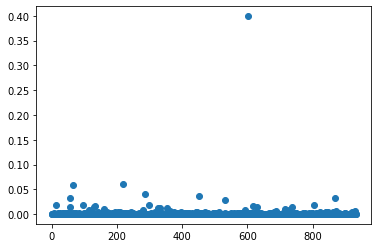

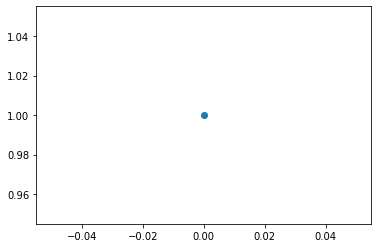

Adjusted PVE
0.5932162591480519
0.3961474568432824


In [157]:
# plt.scatter(np.arange(len(SNPpips_epi)), SNPpips_epi)
# plt.show()

# plt.scatter(np.arange(len(SETpips_epi)), SETpips_epi)
# plt.show()

# print("Adjusted PVE")
# print(SNP_layer.pve+SNP_layer_epi.pve)
# print(SET_layer.pve+SET_layer_epi.pve)

# SNPpips_epi=SNP_layer_epi.pip
# SETpips_epi=SET_layer_epi.pip

# clustering = DBSCAN(eps=0.1, min_samples=2).fit(SNPpips_epi.reshape(-1, 1))
# dict_labels_snp = Counter(clustering.labels_)
# del dict_labels_snp[-1]
# snp_level_indices = np.where(clustering.labels_ == min(dict_labels_snp, key=dict_labels_snp.get))[0]
# snp_level_indices

### Computational Power
ROC curves